<a href="https://colab.research.google.com/github/vanessaaleung/ds-case-studies/blob/master/kidney-stone-treatment/kidney_treatment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Read the data

The data contains three columns: treatment (A or B), stone_size (large or small) and success (0 = Failure or 1 = Success).

In [ ]:
library(readr)
library(dplyr)

data <- read_csv('datasets/kidney_stone_data.csv')
head(data)

Parsed with column specification:
cols(
  treatment = col_character(),
  stone_size = col_character(),
  success = col_double()
)


treatment,stone_size,success
<chr>,<chr>,<dbl>
B,large,1
A,large,1
A,large,0
A,large,1
A,large,1
B,large,1


## 1. Recreate the Treatment X Success summary table
<p>From the treatment and success rate descriptive table, we saw that treatment B performed better on average compared to treatment A (82% vs. 78% success rate). </p>

In [ ]:
data %>% 
  group_by(treatment, success) %>%
  summarise(N = n()) %>% 
  mutate(Freq = round(N/sum(N), 3))

`summarise()` regrouping output by 'treatment' (override with `.groups` argument)


treatment,success,N,Freq
<chr>,<dbl>,<int>,<dbl>
A,0,77,0.220
A,1,273,0.780
B,0,61,0.174
B,1,289,0.826


## 2. Bringing stone size into the picture
<p>What is going on here? When stratified by stone size, treatment A had better results for both large and small stones compared to treatment B (i.e., 73% and 93% v.s. 69% and 87%).</p>

In [ ]:
sum_data <- 
  data %>% 
  group_by(treatment, stone_size, success) %>%
  summarise(N = n()) %>%
  mutate(Freq = round(N/sum(N), 3))

sum_data

`summarise()` regrouping output by 'treatment', 'stone_size' (override with `.groups` argument)


treatment,stone_size,success,N,Freq
<chr>,<chr>,<dbl>,<int>,<dbl>
A,large,0,71,0.270
A,large,1,192,0.730
A,small,0,6,0.069
A,small,1,81,0.931
B,large,0,25,0.312
B,large,1,55,0.688
B,small,0,36,0.133
B,small,1,234,0.867


<p>From the bar plot, we noticed an unbalanced distribution of kidney stone sizes in the two treatment options. Large kidney stone cases tended to be in treatment A, while small kidney stone cases tended to be in treatment B.</p>

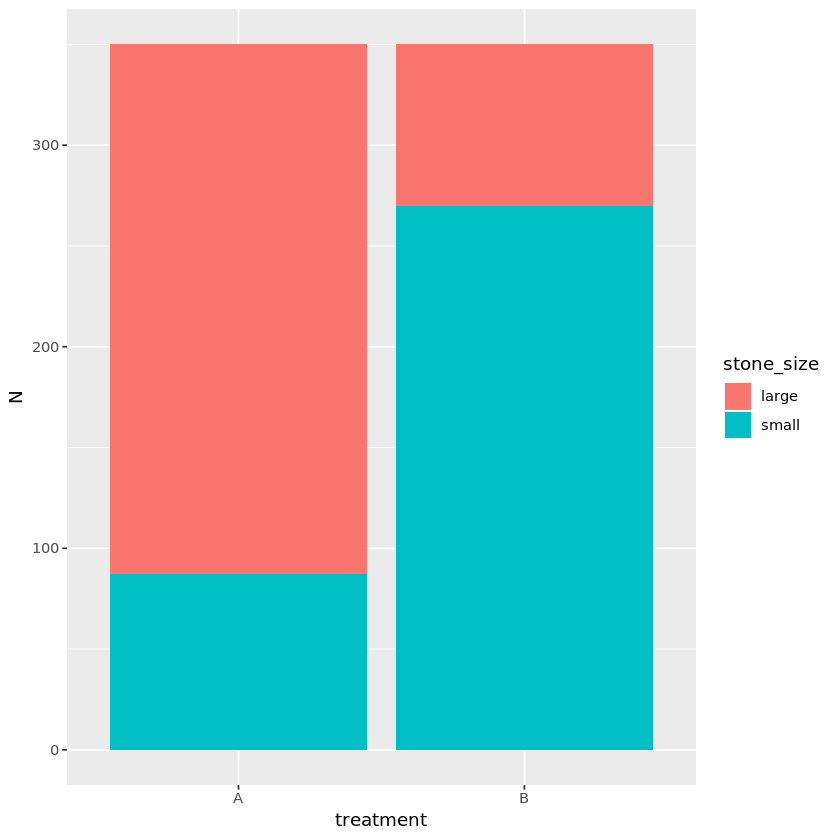

In [ ]:
library(ggplot2)

sum_data %>%
  ggplot(aes(x = treatment, y = N)) + 
  geom_bar(aes(fill = stone_size), stat="identity") 

## 3. Identify and confirm the lurking variable
<p>Let's analyze the association between stone size (i.e., case severity) and treatment assignment using a statistical test called <strong>Chi-squared</strong>. The <strong>Chi-squared</strong> test is appropriate to test associations between two categorical variables. </p>

With the results, we are confident that stone size/case severity is indeed the lurking variable (aka, confounding variable) in this study of kidney stone treatment and success rate. 

In [ ]:
library(broom)

trt_ss <- chisq.test(data$treatment, data$stone_size)
tidy(trt_ss)

statistic,p.value,parameter,method
<dbl>,<dbl>,<int>,<chr>
189.3557,4.395009e-43,1,Pearson's Chi-squared test with Yates' continuity correction


## 4. Remove the confounding effect
In our example, we are testing to see:</p>
<ol>
<li>if the effect of a small stone is the same as a big stone, and </li>
<li>if treatment A is as effective as treatment B. </li>
</ol>

<p>Let's use multiple logistic regression to remove the unwanted effect of stone size.</p>

In [ ]:
m <- glm(data = data, success ~  stone_size + treatment, family = "binomial")
tidy(m)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.0332140,0.1344695,7.683629,1.546436e-14
stone_sizesmall,1.2605654,0.2390027,5.274272,1.332838e-07
treatmentB,-0.3572287,0.2290792,-1.559411,1.188991e-01




Look at the 95% confidence interval

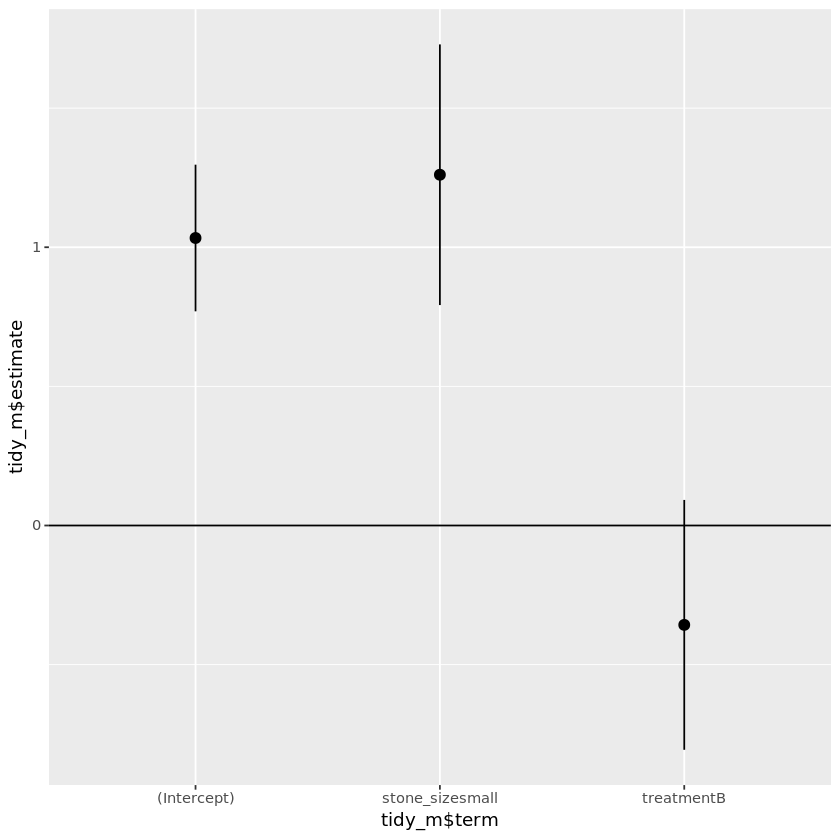

In [ ]:
tidy_m <- tidy(m)

tidy_m %>%
  ggplot(aes(x = tidy_m$term, y = tidy_m$estimate)) + 
  geom_pointrange(aes(ymin = estimate - 1.96 * std.error, 
                      ymax = estimate + 1.96 * std.error)) +
  geom_hline(yintercept = 0)

<p>From the model output, we can conclude that the stone size is positively related to the success rate while the treatment type is not.